# Empathic Art- SVM modeling
by Mickey Krekels 

## Loading imports

In [38]:
# import pandas
import pandas as pd

# import numpy
import numpy as np

# import matplotlib
import matplotlib.pyplot as plt

# import plotly
import plotly.express as px

# import os 
from os import listdir
from os.path import isfile, join

# import librosa
import cv2
import librosa
import librosa.display

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.models import load_model
from sklearn.svm import SVC




# import PIL 
# this is needed for loading large images dataset 
import PIL 
import pathlib
import shutil

# import datetime
from datetime import datetime

#import os
import os
import pickle


## Loading data
This dataset is a combination of Dataset:

- [Toronto emotional speech set (TESS) - Older talker_Happy](https://tspace.library.utoronto.ca/handle/1807/24501)<br>
Author:<br>
Dupuis, Kate; Pichora-Fuller, M. Kathleen
- [The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)](https://zenodo.org/record/1188976#.Y0e8o3ZBy3C)<br>
Author:<br>
Livingstone, Steven R., & Russo, Frank A.
- [The variably intense vocalizations of affect and emotion (VIVAE)](https://pubmed.ncbi.nlm.nih.gov/35129996/)<br>
Author:<br>
Natalie Holz, Pauline Larrouy-Maestri, David Poeppel.

In [2]:
audio_data = {
    "Vivae": "../../data/VIVAE/core_set/", 
    "Ravdess": "../../data/RAVDESS/Audio_Speech_Actors/", 
    "Tess": "../../data/utoronto/data",
}

Loading the dataframe

In [3]:
merged_data = "../../data/merged_data.csv"
df = open(merged_data, "r")
df = pd.read_csv(df)
df.head(10)

,file_name,Speaker,Emotion,Intensity,Dataframe,Duration,Word,Type,Gender
0,S04_fear_peak_03.wav,S04,Fear,peak,VIVAE,0.752472,NaN,Sound,NaN
1,S09_pleasure_strong_08.wav,S09,Pleasure,strong,VIVAE,0.752472,NaN,Sound,NaN
2,S07_pleasure_peak_07.wav,S07,Pleasure,peak,VIVAE,0.672404,NaN,Sound,NaN
3,S04_pain_strong_08.wav,S04,Pain,strong,VIVAE,0.752472,NaN,Sound,NaN
4,S04_fear_strong_05.wav,S04,Fear,strong,VIVAE,0.672404,NaN,Sound,NaN
5,S08_pain_peak_01.wav,S08,Pain,peak,VIVAE,0.536463,NaN,Sound,NaN
6,S06_fear_moderate_03.wav,S06,Fear,moderate,VIVAE,0.752472,NaN,Sound,NaN
7,S09_pain_moderate_09.wav,S09,Pain,moderate,VIVAE,0.672404,NaN,Sound,NaN
8,S01_pain_moderate_04.wav,S01,Pain,moderate,VIVAE,0.536463,NaN,Sound,NaN
9,S07_surprise_strong_01.wav,S07,Surprise,strong,VIVAE,0.989025,NaN,Sound,NaN


For this modeling phase were only interested in the columns filename and Emotion.

## Converting the audio files to Mel-spectograms and saving the result locally

In [4]:
vivae_df = df.loc[df["Dataframe"] == "VIVAE"]
vivae_df

,file_name,Speaker,Emotion,Intensity,Dataframe,Duration,Word,Type,Gender
0,S04_fear_peak_03.wav,S04,Fear,peak,VIVAE,0.752472,NaN,Sound,NaN
1,S09_pleasure_strong_08.wav,S09,Pleasure,strong,VIVAE,0.752472,NaN,Sound,NaN
2,S07_pleasure_peak_07.wav,S07,Pleasure,peak,VIVAE,0.672404,NaN,Sound,NaN
3,S04_pain_strong_08.wav,S04,Pain,strong,VIVAE,0.752472,NaN,Sound,NaN
4,S04_fear_strong_05.wav,S04,Fear,strong,VIVAE,0.672404,NaN,Sound,NaN
...,...,...,...,...,...,...,...,...,...
475,S05_pleasure_moderate_10.wav,S05,Pleasure,moderate,VIVAE,0.505011,NaN,Sound,NaN
476,S08_surprise_moderate_07.wav,S08,Surprise,moderate,VIVAE,1.158889,NaN,Sound,NaN
477,S05_surprise_low_02.wav,S05,Surprise,low,VIVAE,1.880295,NaN,Sound,NaN
478,S09_pleasure_peak_102.wav,S09,Pleasure,peak,VIVAE,0.837800,NaN,Sound,NaN


In [5]:
saving_path = "C:/Users/micke/Desktop/Fontys/S7/Group_project/dataset_merged_local_save/"

audio_file_path_list = []

vivae_df = df[df["Dataframe"] == "VIVAE"]
tess_df = df[df["Dataframe"] == "TESS"]
# ravedess_df = df[df["Dataframe"] == "RAVEDESS"]


for index, row in vivae_df.iterrows():
    audio_file_path_list.append(audio_data["Vivae"] + "/" + row["file_name"])

for index, row in tess_df.iterrows():
    audio_file_path_list.append(audio_data["Tess"] + "/" + row["file_name"])

# for index, row in ravedess_df.iterrows():

#     path = audio_data["Ravdess"]+ "Actor_" + "/" + row["file_name"]
#     audio_file_path_list.append(audio_data["Ravdess"] + "/" + row["file_name"])

# for filename in os.listdir(audio_data["Ravdess"]):
#     f = os.path.join(audio_data["Ravdess"], filename)
#     # checking if it is a file



len(audio_file_path_list)

3280

In [6]:
frames = [vivae_df, tess_df]
df = pd.concat(frames)
df["sound_path"] = audio_file_path_list
df

,file_name,Speaker,Emotion,Intensity,Dataframe,Duration,Word,Type,Gender,sound_path
0,S04_fear_peak_03.wav,S04,Fear,peak,VIVAE,0.752472,NaN,Sound,NaN,../../data/VIVAE/core_set//S04_fear_peak_03.wav
1,S09_pleasure_strong_08.wav,S09,Pleasure,strong,VIVAE,0.752472,NaN,Sound,NaN,../../data/VIVAE/core_set//S09_pleasure_strong...
2,S07_pleasure_peak_07.wav,S07,Pleasure,peak,VIVAE,0.672404,NaN,Sound,NaN,../../data/VIVAE/core_set//S07_pleasure_peak_0...
3,S04_pain_strong_08.wav,S04,Pain,strong,VIVAE,0.752472,NaN,Sound,NaN,../../data/VIVAE/core_set//S04_pain_strong_08.wav
4,S04_fear_strong_05.wav,S04,Fear,strong,VIVAE,0.672404,NaN,Sound,NaN,../../data/VIVAE/core_set//S04_fear_strong_05.wav
...,...,...,...,...,...,...,...,...,...,...
3275,YAF_tough_happy.wav,YAF,Happy,Moderate,TESS,1.866019,tough,Non-Sound,NaN,../../data/utoronto/data/YAF_tough_happy.wav
3276,OAF_nice_angry.wav,OAF,angry,Moderate,TESS,2.275907,nice,Non-Sound,NaN,../../data/utoronto/data/OAF_nice_angry.wav
3277,YAF_gap_ps.wav,YAF,ps,Moderate,TESS,1.652535,gap,Non-Sound,NaN,../../data/utoronto/data/YAF_gap_ps.wav
3278,OAF_phone_fear.wav,OAF,Fear,Moderate,TESS,2.189645,phone,Non-Sound,NaN,../../data/utoronto/data/OAF_phone_fear.wav


Converting the sound files to mel-spectrograms 

In [7]:
# for index, row in df.iterrows():
#     # load audio file
#     path = row["sound_path"]
#     x, sr = librosa.load(path, sr=44100)
#     # compute mel-spectrogram
#     melspectrum = librosa.feature.melspectrogram(y=x, sr=sr, hop_length= 512, window='hann', n_mels=256)
#     # convert to decibels
#     S_dB = librosa.power_to_db(melspectrum, ref=np.max)
#     # convert plot to image
#     img = librosa.display.specshow(S_dB)
#     # save image to disk
#     img.figure.savefig(saving_path + "/"+ row['file_name'] +'.png')
#     plt.close()

In [8]:
image_path_list = []
for index, row in df.iterrows():
    image_path_list.append(saving_path + "/"+ row['file_name'] +'.png')

df["image_path"] = image_path_list

## Saving to Tensorflow format

In [9]:
class_names = df["Emotion"].unique()
print(class_names)

['Fear' 'Pleasure' 'Pain' 'Surprise' 'Angry' 'Achievement' 'Calm' 'Sad'
 'Happy' 'ps' 'Disgust' 'angry']


In [10]:
#remane Emotion value ps to suprise
df["Emotion"] = df["Emotion"].replace("ps", "Surprise")
df["Emotion"] = df["Emotion"].replace("angry", "Angry")
class_names = df["Emotion"].unique()
print(class_names)

['Fear' 'Pleasure' 'Pain' 'Surprise' 'Angry' 'Achievement' 'Calm' 'Sad'
 'Happy' 'Disgust']


In [11]:
unique_count = df['Emotion'].value_counts()
unique_count

Fear           480
Surprise       480
Angry          480
Calm           400
Sad            400
Happy          400
Disgust        400
Pleasure        80
Pain            80
Achievement     80
Name: Emotion, dtype: int64

The values **Pleasure, Pain and Achievement** are not going to be used for this model. There are only 80 labels aviable and that is not enough for training a network.

In [12]:
df = df.loc[df["Emotion"] != 'Pleasure' ]
df = df.loc[df["Emotion"] != 'Pain' ]
df = df.loc[df["Emotion"] != 'Achievement' ]

unique_count = df['Emotion'].value_counts()
unique_count

Fear        480
Surprise    480
Angry       480
Calm        400
Sad         400
Happy       400
Disgust     400
Name: Emotion, dtype: int64

In [13]:
class_names = df["Emotion"].unique()
class_names

array(['Fear', 'Surprise', 'Angry', 'Calm', 'Sad', 'Happy', 'Disgust'],
      dtype=object)

In total we have 7 label types

In [14]:
len(unique_count)

7

Where using this helper function below to save the spectogram into there correct folders
            

In [15]:
def df_to_tensorflow_dataset(copy_dir,df,labels):
    dfs = []

    for label in labels:
        dfs.append(df[df['Emotion'] == label])

    for df_split in dfs:

        for index, row in df_split.iterrows():
            label = row['Emotion']
            path = row['image_path']
            shutil.copy(path, copy_dir + label + "/")

We suffle the dataset

In [16]:
df = df.sample(frac=1).reset_index(drop=True)
df

,file_name,Speaker,Emotion,Intensity,Dataframe,Duration,Word,Type,Gender,sound_path,image_path
0,OAF_cause_angry.wav,OAF,Angry,Moderate,TESS,2.293274,cause,Non-Sound,NaN,../../data/utoronto/data/OAF_cause_angry.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
1,YAF_bite_angry.wav,YAF,Angry,Moderate,TESS,1.704473,bite,Non-Sound,NaN,../../data/utoronto/data/YAF_bite_angry.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
2,YAF_reach_neutral.wav,YAF,Calm,Moderate,TESS,2.281887,reach,Non-Sound,NaN,../../data/utoronto/data/YAF_reach_neutral.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
3,OAF_moon_disgust.wav,OAF,Disgust,Moderate,TESS,1.652535,moon,Non-Sound,NaN,../../data/utoronto/data/OAF_moon_disgust.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
4,YAF_hire_fear.wav,YAF,Fear,Moderate,TESS,2.200172,hire,Non-Sound,NaN,../../data/utoronto/data/YAF_hire_fear.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
...,...,...,...,...,...,...,...,...,...,...,...
3035,YAF_jug_neutral.wav,YAF,Calm,Moderate,TESS,2.275907,jug,Non-Sound,NaN,../../data/utoronto/data/YAF_jug_neutral.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
3036,YAF_lease_angry.wav,YAF,Angry,Moderate,TESS,2.051159,lease,Non-Sound,NaN,../../data/utoronto/data/YAF_lease_angry.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
3037,YAF_youth_fear.wav,YAF,Fear,Moderate,TESS,1.939215,youth,Non-Sound,NaN,../../data/utoronto/data/YAF_youth_fear.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...
3038,OAF_rain_sad.wav,OAF,Sad,Moderate,TESS,2.714017,rain,Non-Sound,NaN,../../data/utoronto/data/OAF_rain_sad.wav,C:/Users/micke/Desktop/Fontys/S7/Group_project...


creating a test and train set RNN model (split of 80:20)

In [17]:
train = df[:int(len(df)*0.8)]
test  = df[int(len(df)*0.8):]

In [18]:
labels = df["Emotion"].unique()
tensorflow_data_path = "C:/Users/micke/Desktop/Fontys/S7/Group_project/"

# df_to_tensorflow_dataset(tensorflow_data_path +'input/training/',train,labels)
# df_to_tensorflow_dataset(tensorflow_data_path +'input/validation/',test,labels)

In [19]:
data_dir = pathlib.Path(tensorflow_data_path + 'input/training/')

image_size = cv2.imread(df.image_path[0]).shape

batch_size = 32
img_height = image_size[0]
img_width = image_size[1]

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2432 files belonging to 7 classes.
Using 1946 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2432 files belonging to 7 classes.
Using 486 files for validation.


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
class_len = len(class_names)

cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[img_height, img_width, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
# cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
## For Binary Classification
cnn.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear')) #
## for mulitclassification
cnn.add(tf.keras.layers.Dense(class_len, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))
cnn.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])

In [42]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 144, 216, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 108, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 108, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 62208)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               7962752   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [44]:
# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = train_ds, validation_data = val_ds, epochs = 15)

Epoch 1/15
61/61 [==============================] - 20s 326ms/step - loss: 0.8936 - accuracy: 0.1521 - val_loss: 0.8904 - val_accuracy: 0.1543
Epoch 2/15
61/61 [==============================] - 19s 308ms/step - loss: 0.8874 - accuracy: 0.1521 - val_loss: 0.8864 - val_accuracy: 0.1543
Epoch 3/15
61/61 [==============================] - 19s 308ms/step - loss: 0.8846 - accuracy: 0.1521 - val_loss: 0.8845 - val_accuracy: 0.1543
Epoch 4/15
61/61 [==============================] - 19s 317ms/step - loss: 0.8831 - accuracy: 0.1521 - val_loss: 0.8833 - val_accuracy: 0.1543
Epoch 5/15
61/61 [==============================] - 19s 310ms/step - loss: 0.8821 - accuracy: 0.1572 - val_loss: 0.8826 - val_accuracy: 0.1667
Epoch 6/15
61/61 [==============================] - 18s 302ms/step - loss: 0.5916 - accuracy: 0.1624 - val_loss: 0.5820 - val_accuracy: 0.1399
Epoch 7/15
61/61 [==============================] - 19s 309ms/step - loss: 0.5727 - accuracy: 0.1619 - val_loss: 0.5818 - val_accuracy: 0.1399

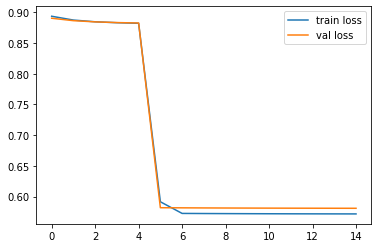

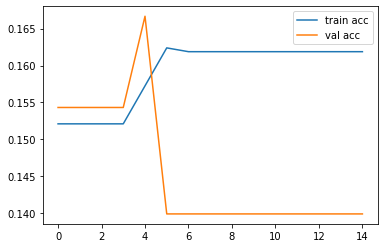

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

The CNN + SVM model does not preform well under training. Therefore in the next chapter where going to look at regual SVM 

In [46]:
cnn.save(tensorflow_data_path +'models/model_CNN_v3.h5')

## Using Normal SVM
Loading the images and labels into memory 

In [27]:
training_data = []

for index, row in df.iterrows():
    label = row['Emotion']
    path = row['image_path']
    img_array=cv2.imread(path)
    img_array = img_array/255 #normalize    
    training_data.append([img_array,label])

In [28]:
X=[]
y=[]
lenofimage = len(training_data)


for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)

In [29]:
y=np.array(y)

Creating a training and test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Training the network

In [32]:
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

Saving the model as a pickle object

In [34]:
with open(tensorflow_data_path + 'model_pkl', 'wb') as files:
    pickle.dump(svc, files)

Validating the model score with a prediction

In [35]:
y2 = svc.predict(X_test)

In [37]:
print("Accuracy on unknown data is",accuracy_score(y_test,y2))

Accuracy on unknown data is 0.9723684210526315


The model has a accuracy score of 0.9723684210526315 on the validating data

In [39]:
print("Accuracy on unknown data is",classification_report(y_test,y2))

Accuracy on unknown data is               precision    recall  f1-score   support

       Angry       0.95      0.97      0.96       115
        Calm       1.00      1.00      1.00       109
     Disgust       1.00      1.00      1.00       103
        Fear       0.94      0.93      0.93       120
       Happy       1.00      1.00      1.00        98
         Sad       1.00      1.00      1.00       102
    Surprise       0.93      0.93      0.93       113

    accuracy                           0.97       760
   macro avg       0.97      0.97      0.97       760
weighted avg       0.97      0.97      0.97       760



Final look at all of the predictions 

In [40]:
result = pd.DataFrame({'original' : y_test,'predicted' : y2})
result


,original,predicted
0,Disgust,Disgust
1,Calm,Calm
2,Angry,Angry
3,Disgust,Disgust
4,Happy,Happy
...,...,...
755,Calm,Calm
756,Surprise,Surprise
757,Disgust,Disgust
758,Fear,Fear


# conclusion 
The CNN + SVM model did not preform well, the network had a hard time correctly categorizing the images to the right label. On the other hand,  
the regular SVM model performs really well, with emotion classification, with an accuracy score on unknown data of ≈0.97. <br>

In short, the regular SVM model is a good choice for our emotion prediction system. 
